In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch 
from argparse import Namespace
from tqdm import tqdm
import pickle 

# Add the path to the directory containing the sybil module
sys.path.append('/workspace/home/tengyuezhang/sybil_cect/code/Sybil/')
from sybil.utils.metrics import concordance_index, get_survival_metrics
from sybil import Sybil, Serie
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
# Load data
df = pd.read_csv('/workspace/home/tengyuezhang/sybil_cect/results/all_nlst_with_risk_scores_baseline.csv')

In [3]:
# Load checkpoint (to get censor distribution on training set that is used to calculate c-index)
model = Sybil("sybil_ensemble")

/home/tengyuezhang/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tengyuezhang/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Process labels to get a binary label for each year

In [4]:
max_followup = 1

In [23]:
# Get y label for each year 

def calculate_y_seq(event, time_to_event, max_followup=6):
    # Initialize y_0, y_1, ..., y_5 as 0
    y_seq = np.zeros(max_followup)

    if event == 1:
        # Convert time_to_event to integer index (year)
        event_year = int(time_to_event)
        
        # Ensure the event year does not exceed the follow-up period
        event_year = min(event_year, max_followup)
        
        # Set all y_i from the event year onward to 1
        y_seq[event_year:] = 1
    
    return y_seq

# Initialize columns for y_0 to y_5 in the DataFrame
for i in range(max_followup):
    df[f'y_{i}'] = np.nan

# Iterate through each row to calculate y_0, ..., y_5
for index, row in df.iterrows():
    event = row['event']
    time_to_event = row['years_to_event']
    
    # Calculate y_seq
    y_seq = calculate_y_seq(event, time_to_event, max_followup=max_followup)
    
    # Assign y_0, ..., y_5 to the corresponding columns in the DataFrame
    for i in range(max_followup):
        df.at[index, f'y_{i}'] = y_seq[i]

# Now, df will have new columns y_0, y_1, ..., y_5
# print(df.head(20))

In [32]:
df['event'].sum()

144

In [31]:
dataset_percent_positive = (df['y_0'].sum() / len(df)) 
df['y_0'].sum()

44.0

In [35]:
(df['years_to_event'] < 1).sum()

44

In [34]:
# Year 1: 
print(F"Total number of patients: {len(df)}")
print(f"Percentage of cases developing LC within one year: {df['y_0'].sum() / len(df)}")
print(f"Number of cases developing LC within one year: {df['y_0'].sum()}")

Total number of patients: 2328
Percentage of cases developing LC within one year: 0.018900343642611683
Number of cases developing LC within one year: 44.0


# Calculate time-dependent AUC and C-index on the entire dataset 

In [8]:
# get scores and labels 
selected_columns = ['pred_risk_year_0', 'pred_risk_year_1', 'pred_risk_year_2', 
                    'pred_risk_year_3', 'pred_risk_year_4', 'pred_risk_year_5']
# selected_columns = ['pred_risk_year_0']
# Convert predicted risk scores to a list of lists (shape: [number of patients, 6, 1])
pred_risk_scores = df[selected_columns].values.tolist()

# Convert event times and event observed to lists
event_times = df['years_to_event'].tolist()
event_observed = df['event'].tolist()

input_dict = {
    "probs": torch.tensor(pred_risk_scores), 
    "censors": torch.tensor(event_times), 
    "golds": torch.tensor(event_observed)
}

args = Namespace(
    max_followup=max_followup, censoring_distribution=model._censoring_dist
)

nlst_out = get_survival_metrics(input_dict, args)

# print(f"nlst_out: \n{nlst_out}")

Then, plot the 6-year time-dependent AUROC. 

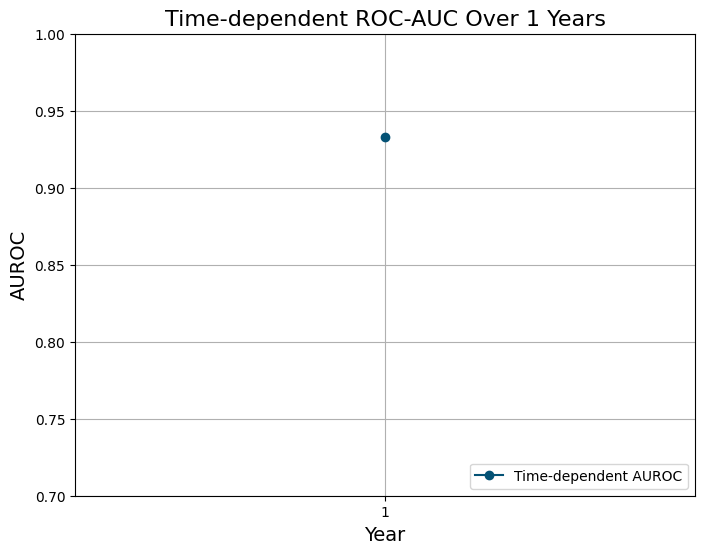

In [9]:
# Extracting the AUC values for each year
years = list(range(1, max_followup + 1))
auc_values = [nlst_out[f'{year}_year_auc'] for year in years]


# Plotting the time-dependent AUROC
plt.figure(figsize=(8, 6))
plt.plot(years, auc_values, marker='o', linestyle='-', color='#045275', label='Time-dependent AUROC')

# Adding plot labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('AUROC', fontsize=14)
plt.title(f'Time-dependent ROC-AUC Over {max_followup} Years', fontsize=16)
plt.xticks(years)
plt.ylim(0.7, 1.0)  # Adjust the y-axis limits if needed
plt.grid(True)
plt.legend(loc='lower right')

# Show the plot
plt.show()

[0.435808175197848]


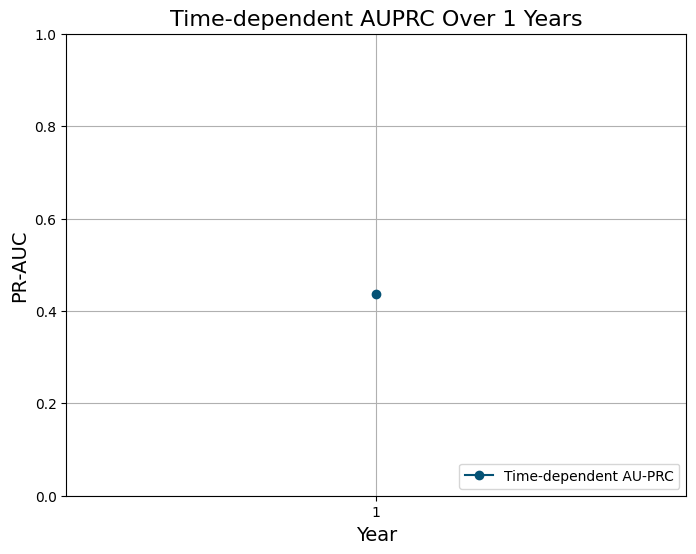

In [10]:
pr_auc_values = [nlst_out[f'{year}_year_prauc'] for year in years]
print(pr_auc_values)
plt.figure(figsize=(8, 6))
plt.plot(years, pr_auc_values, marker='o', linestyle='-', color='#045275', label='Time-dependent AU-PRC')

# Adding plot labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('PR-AUC', fontsize=14)
plt.title(f'Time-dependent AUPRC Over {max_followup} Years', fontsize=16)
plt.xticks(years)
plt.ylim(0,1)  # Adjust the y-axis limits if needed
plt.grid(True)
plt.legend(loc='lower right')

# Show the plot
plt.show()

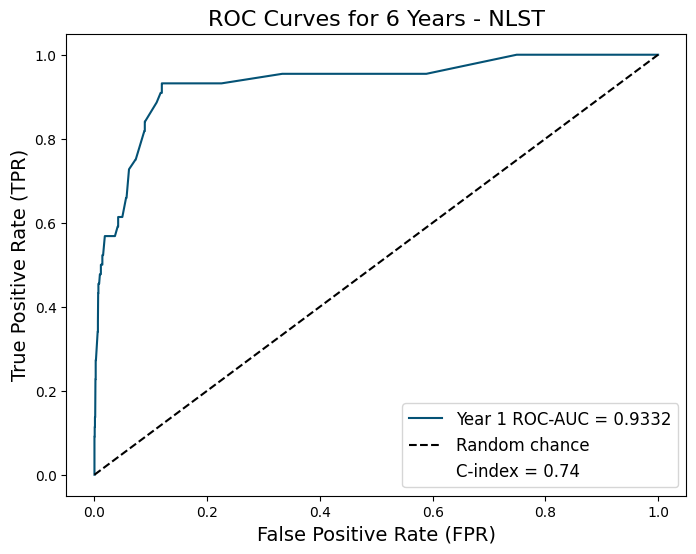

In [12]:
# Plotting
plt.figure(figsize=(8, 6))
colors = ['#045275', '#089099', '#7CCBA2', '#FABF7B', '#E05C5C', '#AB1866']

for year in range(1, max_followup+1):
    # Extract FPR, TPR, and AUROC for the current year
    roc_curve_data = nlst_out[f'{year}_year_roc_curve']
    fpr = roc_curve_data['fpr']
    tpr = roc_curve_data['tpr']
    auroc = nlst_out[f'{year}_year_auc']

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Year {year} ROC-AUC = {auroc:.4f}', color=colors[year-1])

# Plotting random chance
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')

# Include C-index in the legend
plt.plot([], [], ' ', label=f"C-index = {nlst_out['c_index']:.2f}")

# Set plot labels and title
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curves for 6 Years - NLST', fontsize=16)
plt.legend(loc='lower right', fontsize=12)

# Show plot
plt.show()

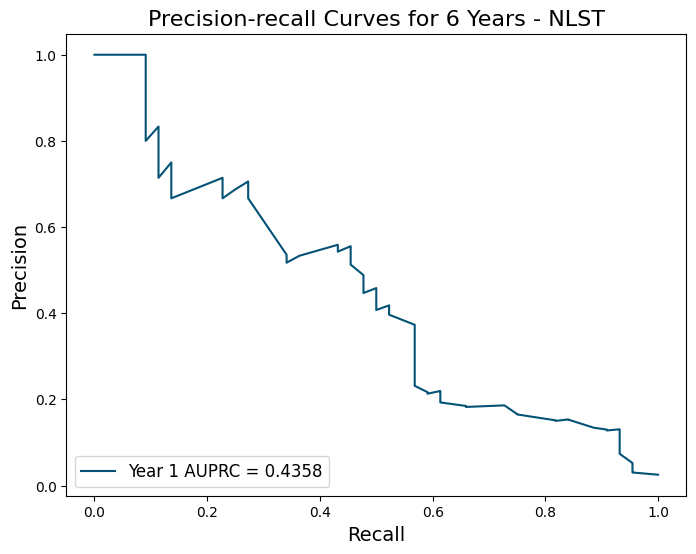

In [13]:
plot_ci = False  
colors = ['#045275', '#089099', '#7CCBA2', '#FABF7B', '#E05C5C', '#AB1866']

# Extract the C-index
c_index = nlst_out['c_index']

# Plotting
plt.figure(figsize=(8, 6))

for year in range(1, max_followup+1):
    pr_curve_data = nlst_out[f'{year}_year_pr_curve']
    precision = pr_curve_data['precision'] 
    recall = pr_curve_data['recall']
    pr_auc = nlst_out[f'{year}_year_prauc']

    # Plot precision-recall curve
    plt.plot(recall, precision, label=f'Year {year} AUPRC = {pr_auc:.4f}', color=colors[year-1])

# Plotting random chance
# plt.plot([0, 1], [0, 1], 'k--', label='Random chance')

# Include C-index in the legend
# plt.plot([], [], ' ', label=f'C-index = {c_index:.2f}')

# Set plot labels and title
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-recall Curves for 6 Years - NLST', fontsize=16)
plt.legend(loc='lower left', fontsize=12)

# Show plot
plt.show()

# Bootstrapping (AUROC, C-index, etc) 

If this hasn't been calculated before, or you want to re-calculate the values, perform bootstrapping and save the results. 

In [14]:
# Parameters
n_bootstraps = 5000 
random_seed = 42 
np.random.seed(random_seed)

# Define where to save bootstrapping results 
bootstrap_result_path = '/workspace/home/tengyuezhang/sybil_cect/results/nlst_baseline/bootstrap_results.pkl'

In [24]:
auroc_scores_all_years = {f'year_{i}': [] for i in range(6)} 
auprc_scores_all_years = {f'year_{i}': [] for i in range(6)} 

# define args for c-index calculation 
args = Namespace(
    max_followup=6, censoring_distribution=model._censoring_dist
)

# to store bootstrapped metrics 
bootstrapped_auroc = {f'year_{i+1}': [] for i in range(6)}
bootstrapped_auprc = {f'year_{i+1}': [] for i in range(6)}
bootstrapped_c_indices = [] 

# for i in range(n_bootstraps): 
for i in tqdm(range(n_bootstraps), desc="Bootstrapping", ncols=100):
    # resample data with replacement 
    bootstrap_indices = resample(range(len(df)), replace=True, n_samples=len(df))
    df_bootstrap = df.iloc[bootstrap_indices]
    pred_risk_scores_bootstrap = df_bootstrap[selected_columns].values.tolist()
    event_times_bootstrap = df_bootstrap['years_to_event'].tolist() 
    event_observed_bootstrap = df_bootstrap['event'].tolist() 
    
    input_dict_bootstrap = {
        "probs": torch.tensor(pred_risk_scores_bootstrap), 
        "censors": torch.tensor(event_times_bootstrap), 
        "golds": torch.tensor(event_observed_bootstrap)
    }
    
    bootstrap_metrics = get_survival_metrics(input_dict_bootstrap, args)
    
    # print(bootstrap_metrics) 
    
    for year in range(1, 7): 
        bootstrapped_auroc[f'year_{year}'].append(bootstrap_metrics[f'{year}_year_auc'])
        bootstrapped_auprc[f'year_{year}'].append(bootstrap_metrics[f'{year}_year_prauc'])
    bootstrapped_c_indices.append(bootstrap_metrics['c_index'])
    


Bootstrapping: 100%|██████████████████████████████████████████| 5000/5000 [1:30:54<00:00,  1.09s/it]


In [28]:
import pickle 
bootstrap_results = {
    'bootstrapped_auroc': bootstrapped_auroc,  # AUROC
    'bootstrapped_c_indices': bootstrapped_c_indices,  # C-index
    'bootstrapped_auprc': bootstrapped_auprc, 
}
with open(bootstrap_result_path, 'wb') as f:
    pickle.dump(bootstrap_results, f)

Load data from the pickle file. 

In [15]:
# Load the dictionary from the pickle file
with open(bootstrap_result_path, 'rb') as f:
    loaded_results = pickle.load(f)

# Accessing the loaded data
bootstrapped_auroc = loaded_results['bootstrapped_auroc']
bootstrapped_c_indices = loaded_results['bootstrapped_c_indices']
bootstrapped_auprc = loaded_results['bootstrapped_auprc']

Calculate means and CIs 

In [17]:
# 1) calculate mean AUROC and CIs for each year
auroc_results = {}
for year in range(1, max_followup+1):
    auroc_scores = bootstrapped_auroc[f'year_{year}']
    mean_auroc = np.mean(auroc_scores)
    lower_bound = np.percentile(auroc_scores, 2.5)
    upper_bound = np.percentile(auroc_scores, 97.5)
    auroc_results[f'year_{year}'] = {
        'mean_auroc': mean_auroc,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

print('======== AUROC ========')
for year in range(1, max_followup+1): 
    year_auroc = auroc_results[f'year_{year}']['mean_auroc']
    year_lower = auroc_results[f'year_{year}']['lower_bound']
    year_upper = auroc_results[f'year_{year}']['upper_bound']
    print(f'Year {year} mean AUROC={year_auroc:.4f} (CI: [{year_lower:.2f}-{year_upper:.2f}])')
    
# 2) calculate mean AUPRC and CIs for each year 
auprc_results = {}
for year in range(1, max_followup+1):
    auprc_scores = bootstrapped_auprc[f'year_{year}']
    mean_auprc = np.mean(auprc_scores)
    lower_bound = np.percentile(auprc_scores, 2.5)
    upper_bound = np.percentile(auprc_scores, 97.5)
    auprc_results[f'year_{year}'] = {
        'mean_auprc': mean_auprc,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

print('======== AUPRC ========')
for year in range(1, max_followup+1): 
    year_auprc = auprc_results[f'year_{year}']['mean_auprc']
    year_lower = auprc_results[f'year_{year}']['lower_bound']
    year_upper = auprc_results[f'year_{year}']['upper_bound']
    print(f'Year {year} mean AUPRC={year_auprc:.4f} (CI: [{year_lower:.2f}-{year_upper:.2f}])')

# 3) calculate mean C-index and CI
mean_c_index = np.mean(bootstrapped_c_indices)
c_index_lower_bound = np.percentile(bootstrapped_c_indices, 2.5)
c_index_upper_bound = np.percentile(bootstrapped_c_indices, 97.5)

print('======== C-index ========')
print(f'Mean C-index={mean_c_index:.4f} (CI: [{c_index_lower_bound:.2f}-{c_index_upper_bound:.2f}])')

======== AUROC ========
Year 1 mean AUROC=0.9333 (CI: [0.89-0.97])
======== AUPRC ========
Year 1 mean AUPRC=0.4358 (CI: [0.27-0.59])
======== C-index ========
Mean C-index=0.7421 (CI: [0.70-0.79])


# Plot ROC curves and time-dependent AUROC with CI

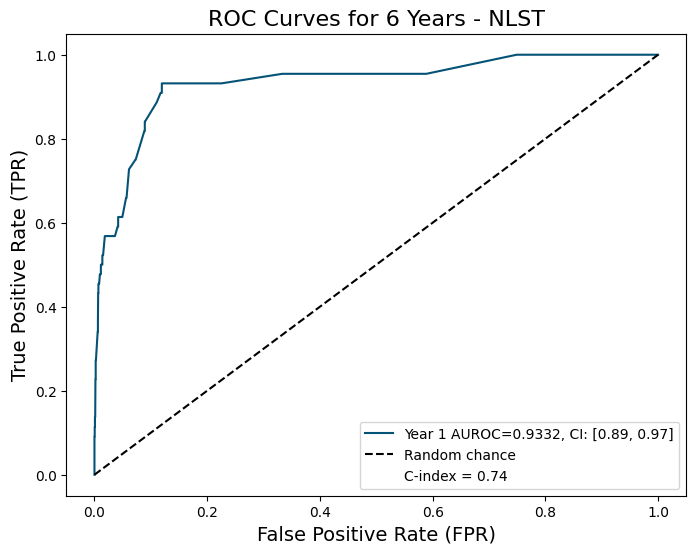

In [18]:
# Extract the C-index
c_index = nlst_out['c_index']

# Plotting
plt.figure(figsize=(8, 6))

for year in range(1, max_followup+1):
    # Extract FPR, TPR, and AUROC for the current year
    roc_curve_data = nlst_out[f'{year}_year_roc_curve']
    fpr = roc_curve_data['fpr']
    tpr = roc_curve_data['tpr']
    year_auroc = nlst_out[f'{year}_year_auc']
    year_lower = auroc_results[f'year_{year}']['lower_bound']
    year_upper = auroc_results[f'year_{year}']['upper_bound']

    # Plot ROC curve
    plt.plot(fpr, tpr, 
            label=f'Year {year} AUROC={year_auroc:.4f}, CI: [{year_lower:.2f}, {year_upper:.2f}]', 
             color=colors[year-1]
    )

# Plotting random chance
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')

# Include C-index in the legend
plt.plot([], [], ' ', label=f'C-index = {c_index:.2f}')

# Set plot labels and title
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curves for 6 Years - NLST', fontsize=16)
plt.legend(loc='lower right', fontsize=10)

# Show plot
plt.show()

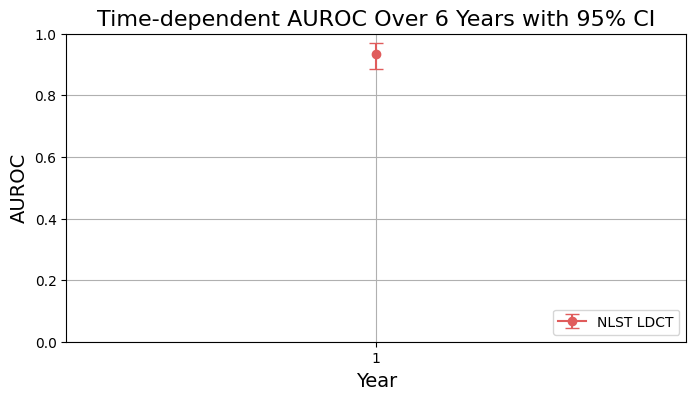

In [19]:
# Extracting the AUC values for each year
auc_values = [nlst_out[f'{year}_year_auc'] for year in years]
auc_lower = [auroc_results[f'year_{year}']['lower_bound'] for year in years]
auc_upper = [auroc_results[f'year_{year}']['upper_bound'] for year in years]

# Calculate the errors for the error bars
auc_errors = [
    [auc_values[i] - auc_lower[i] for i in range(max_followup)],  # Lower errors
    [auc_upper[i] - auc_values[i] for i in range(max_followup)]   # Upper errors
]

# Plotting the time-dependent AUROC with error bars
plt.figure(figsize=(8, 4))
plt.errorbar(years, 
             auc_values, 
             yerr=auc_errors, 
             fmt='o', 
             linestyle='-', 
             color='#E05C5C', 
             label='NLST LDCT', 
             capsize=5
)

# Adding plot labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('AUROC', fontsize=14)
plt.title('Time-dependent AUROC Over 6 Years with 95% CI', fontsize=16)
plt.xticks(years)
plt.ylim(0, 1.0)  # Adjust the y-axis limits if needed
plt.grid(True)
plt.legend(loc='lower right')

# Show the plot
plt.show()

# Plot Precision-recall Curve and time-dependent AUPRC with CIs

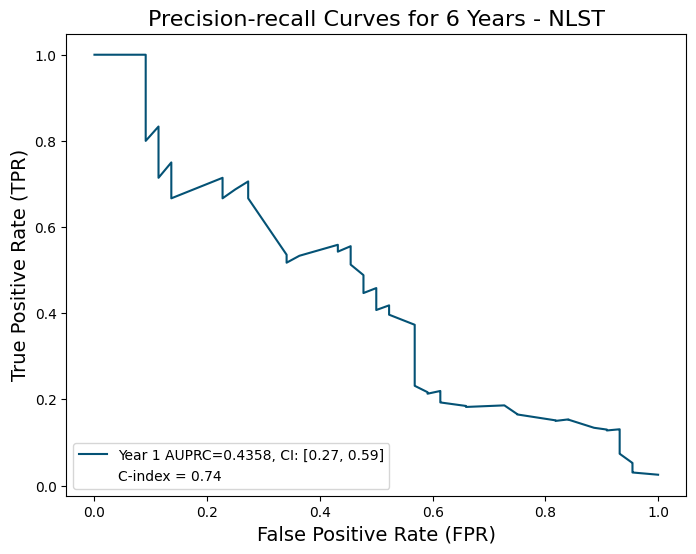

In [20]:
# Extract the C-index
c_index = nlst_out['c_index']

# Plotting
plt.figure(figsize=(8, 6))

for year in range(1, max_followup+1):
    # Extract FPR, TPR, and AUROC for the current year
    pr_curve_data = nlst_out[f'{year}_year_pr_curve']
    recall = pr_curve_data['recall']
    precision = pr_curve_data['precision']
    year_auprc = nlst_out[f'{year}_year_prauc']
    year_lower = auprc_results[f'year_{year}']['lower_bound']
    year_upper = auprc_results[f'year_{year}']['upper_bound']

    # Plot ROC curve
    plt.plot(recall, precision, 
            label=f'Year {year} AUPRC={year_auprc:.4f}, CI: [{year_lower:.2f}, {year_upper:.2f}]', 
             color=colors[year-1]
    )

# Include C-index in the legend
plt.plot([], [], ' ', label=f'C-index = {c_index:.2f}')

# Set plot labels and title
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Precision-recall Curves for 6 Years - NLST', fontsize=16)
plt.legend(loc='lower left', fontsize=10)

# Show plot
plt.show()

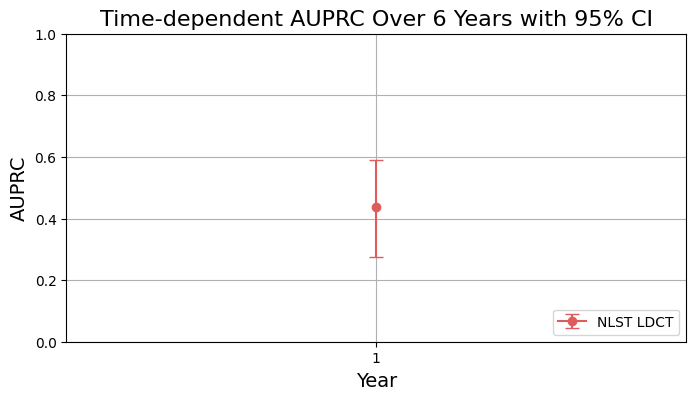

In [21]:
# Extracting the AUC values for each year
# print(nlst_out.keys())
auprc_values = [nlst_out[f'{year}_year_prauc'] for year in years]
auprc_lower = [auprc_results[f'year_{year}']['lower_bound'] for year in years]
auprc_upper = [auprc_results[f'year_{year}']['upper_bound'] for year in years]

# Calculate the errors for the error bars
auprc_errors = [
    [auprc_values[i] - auprc_lower[i] for i in range(max_followup)],  # Lower errors
    [auprc_upper[i] - auprc_values[i] for i in range(max_followup)]   # Upper errors
]

# Plotting the time-dependent AUROC with error bars
plt.figure(figsize=(8, 4))
plt.errorbar(years, 
             auprc_values, 
             yerr=auprc_errors, 
             fmt='o', 
             linestyle='-', 
             color='#E05C5C', 
             label='NLST LDCT', 
             capsize=5
)

# Adding plot labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('AUPRC', fontsize=14)
plt.title('Time-dependent AUPRC Over 6 Years with 95% CI', fontsize=16)
plt.xticks(years)
plt.ylim(0, 1.0)  # Adjust the y-axis limits if needed
plt.grid(True)
plt.legend(loc='lower right')

# Show the plot
plt.show()

# Classification
Use Youden Index to perform classification. Plot confusion matrix. 

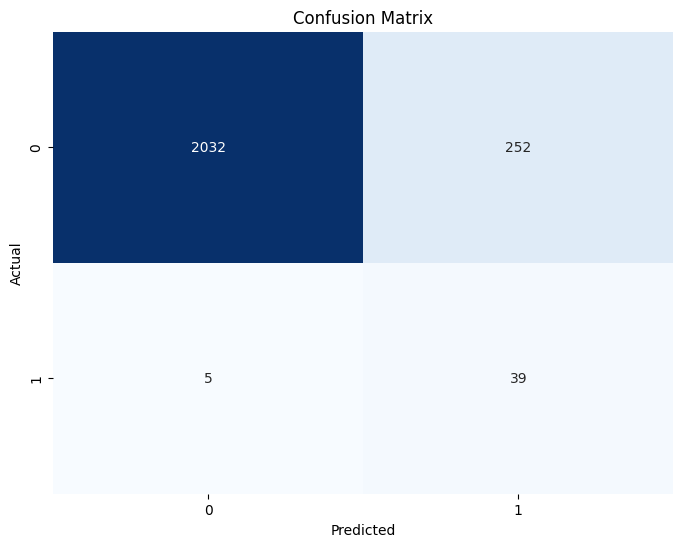

In [22]:
optimal_threshold = 0.0121

# Calculate ROC curve and Youden's index
y_true = df['y_0']
y_scores = df['pred_risk_year_0']

# Use this optimal threshold to classify patients
df['predicted_risk'] = (df['pred_risk_year_0'] >= optimal_threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(df['y_0'], df['predicted_risk'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()